In [1]:
## load packages
import pandas as pd
import numpy as np
import re
#from scipy.stats.stats import pearsonr   
import datetime
#from sklearn import preprocessing
#from sklearn import linear_model
import statsmodels.api as sm
#import pygsheets
#import pycountry
import time

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib

# import seaborn as sns
# plt.style.use('ggplot')
# sns.set_palette('deep')

from pylab import rcParams
from collections import OrderedDict
plt.style.use('ggplot')
figsize = OrderedDict((('width', 14), ('height', 5)))
rcParams['figure.figsize'] = figsize.values()
rcParams['font.size'] = 15
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13
rcParams['legend.frameon'] = True
rcParams['legend.framealpha'] = 0.8
rcParams['legend.fontsize'] = 13


/home/nicolas/anaconda3/envs/forecasting-venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
radiation = pd.read_pickle('../data/pickles/df_total_radiation_res15T.pickle')

In [3]:
solar_production = pd.read_pickle('../data/pickles/df_ss_pv_res15T.pickle')

## exploration

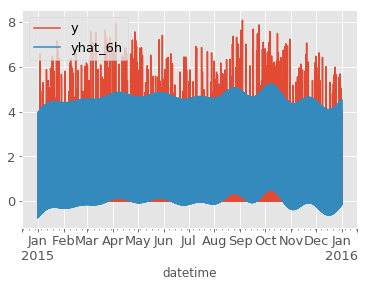

In [4]:
solar_production[['y','yhat_6h']].plot()

/home/nicolas/anaconda3/envs/forecasting-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=2880,center=False).mean()
  """Entry point for launching an IPython kernel.


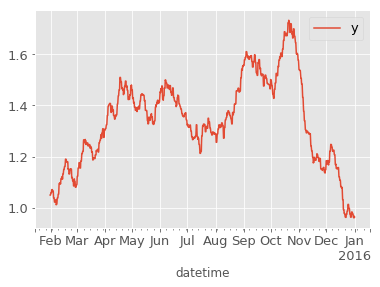

In [5]:
pd.rolling_mean(solar_production[['y']], 30*24*4).plot()

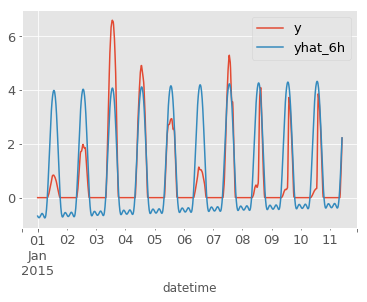

In [8]:
solar_production[['y','yhat_6h']].iloc[:1000,:].plot()

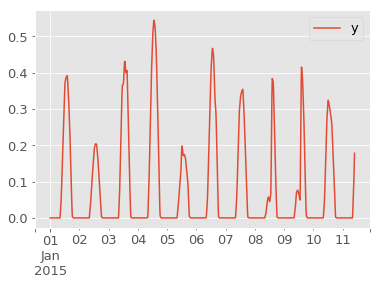

In [9]:
radiation.iloc[:1000,:].plot()

/home/nicolas/anaconda3/envs/forecasting-venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


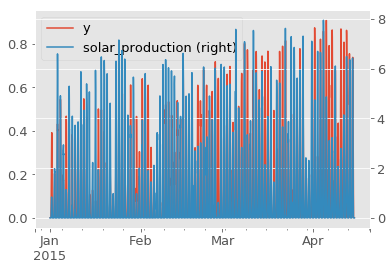

In [10]:
SELECTION_MIN = 0
SELECTION_MAX = 10000

radiation_production_selection = radiation.iloc[SELECTION_MIN:SELECTION_MAX,:]
radiation_production_selection

radiation_production_selection['solar_production'] = solar_production[['y']].iloc[SELECTION_MIN:SELECTION_MAX,:]
radiation_production_selection.plot(secondary_y=['solar_production'])

## regression

In [11]:
radiation_production_selection.head()

,y,solar_production
2015-01-01 00:00:00,0.0,0.0
2015-01-01 00:15:00,0.0,0.0
2015-01-01 00:30:00,0.0,0.0
2015-01-01 00:45:00,0.0,0.0
2015-01-01 01:00:00,0.0,0.0


In [12]:
regression_frame_raw = radiation_production_selection.copy()
regression_frame_raw.head()

,y,solar_production
2015-01-01 00:00:00,0.0,0.0
2015-01-01 00:15:00,0.0,0.0
2015-01-01 00:30:00,0.0,0.0
2015-01-01 00:45:00,0.0,0.0
2015-01-01 01:00:00,0.0,0.0


In [15]:
regression_frame_raw.reset_index().iloc[35:45,:]

,index,y,solar_production
35,2015-01-01 08:45:00,0.035625,0.083524
36,2015-01-01 09:00:00,0.049875,0.116934
37,2015-01-01 09:15:00,0.070375,0.159916
38,2015-01-01 09:30:00,0.097125,0.212470
39,2015-01-01 09:45:00,0.123875,0.265024
40,2015-01-01 10:00:00,0.150625,0.317578
41,2015-01-01 10:15:00,0.177000,0.371859
42,2015-01-01 10:30:00,0.203000,0.427869
43,2015-01-01 10:45:00,0.229000,0.483878
44,2015-01-01 11:00:00,0.255000,0.539887


In [16]:
regression_frame_raw.reset_index().iloc[35+192:45+192,:]

,index,y,solar_production
227,2015-01-03 08:45:00,0.053125,1.001748
228,2015-01-03 09:00:00,0.074375,1.402448
229,2015-01-03 09:15:00,0.103625,1.843979
230,2015-01-03 09:30:00,0.140875,2.326341
231,2015-01-03 09:45:00,0.178125,2.808704
232,2015-01-03 10:00:00,0.215375,3.291067
233,2015-01-03 10:15:00,0.250375,3.745825
234,2015-01-03 10:30:00,0.283125,4.172979
235,2015-01-03 10:45:00,0.315875,4.600134
236,2015-01-03 11:00:00,0.348625,5.027288


In [17]:
# _1 means 1 day before


def generate_lags(df, var, lags):
    
    for lag in lags:
        if lag > 0:
            str_lag = str(lag)
        else:
            str_lag = 'f' + str(abs(lag))
        df[var + '_' + str_lag] = df[var].shift(96 * lag)

In [18]:

generate_lags(regression_frame_raw, 'y', [2,3,4,5,6,7,8])
regression_frame_raw.reset_index().iloc[1400+192,:]

index               2015-01-17 14:00:00
y                                0.4765
solar_production                1.81871
y_2                              0.1185
y_3                             0.10875
y_4                            0.442625
y_5                             0.53925
y_6                            0.453625
y_7                             0.28875
y_8                            0.373375
Name: 1592, dtype: object

In [19]:
# gen var for forecasted value of solar activity at t
generate_lags(regression_frame_raw, 'solar_production', [-2])
regression_frame_raw.rename(columns={'solar_production_f2':'solar_production_forecast_2days'},inplace=True)
generate_lags(regression_frame_raw, 'solar_production_forecast_2days', [2])

regression_frame_raw.reset_index().iloc[1400+192,:]

index                                2015-01-17 14:00:00
y                                                 0.4765
solar_production                                 1.81871
y_2                                               0.1185
y_3                                              0.10875
y_4                                             0.442625
y_5                                              0.53925
y_6                                             0.453625
y_7                                              0.28875
y_8                                             0.373375
solar_production_forecast_2days                  6.14375
solar_production_forecast_2days_2                1.81871
Name: 1592, dtype: object

In [47]:
DEPENDENT = 'y'
INDEPENDENTS = ['y_2']
INDEPENDENTS = ['y_2','solar_production_forecast_2days_2']
INDEPENDENTS = ['y_2','y_3','y_4']
INDEPENDENTS = ['y_2','y_3','y_4','solar_production_forecast_2days_2']
INDEPENDENTS = ['y_2','y_3','y_4',
                'y_5','y_6','y_7',
                'solar_production_forecast_2days_2']
INDEPENDENTS = ['y_2','y_3','y_4',
                'y_5','y_6','y_7']

TEST_SET_SIZE = int(SELECTION_MAX / 3)

In [48]:
regression_frame = regression_frame_raw[[DEPENDENT] + INDEPENDENTS]
regression_frame = regression_frame[~pd.isnull(regression_frame).any(axis=1)]
regression_frame['constant'] = 1

X_train = regression_frame.iloc[:-TEST_SET_SIZE,1:]
X_test = regression_frame.iloc[-TEST_SET_SIZE:,1:]
X_all = regression_frame.iloc[:,1:]

y_train = np.array(regression_frame.iloc[:-TEST_SET_SIZE,0])
y_test = np.array(regression_frame.iloc[-TEST_SET_SIZE:,0])

print(len(regression_frame))
print(len(y_test))

mod = sm.OLS(y_train,X_train)
res = mod.fit()

y_hat = res.predict(X_all)
y_hat_test = res.predict(X_test)

regression_frame_raw[DEPENDENT + '_predicted'] = y_hat

res.summary()

9328
3333


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     2899.
Date:                Thu, 12 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:27:04   Log-Likelihood:                 5876.4
No. Observations:                5995   AIC:                        -1.174e+04
Df Residuals:                    5988   BIC:                        -1.169e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_2            0.2554      0.013     19.228      0.000       0.229       0.281
y_3           -0.0708      0.014     -4.900      0.000      -0.099      -0.042
y_4            0.1200      0.014      8.404      0.000       0.092       0.148
y_5            0.1275      0.014      8.911      0.000       0.099       0.156
y_6            0.2730      0.014     19.179      0.000       0.245       0.301
y_7            0.3011      0.013     22.437      0.000       0.275       0.327
constant       0.0060      0.001      4.229      0.000       0.003       0.009
==============================================================================
Omnibus:                      679.833   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4591.281
Skew:                          -0.321   Prob(JB):                         0.00
Kurtosis:                       7.239   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
regression_frame_raw

,y,solar_production,y_2,y_3,y_4,y_5,y_6,y_7,y_8,solar_production_forecast_2days,solar_production_forecast_2days_2,y_predicted
2015-01-01 00:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 00:15:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 00:30:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 00:45:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 01:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 01:15:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 01:30:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 01:45:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 02:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2015-01-01 02:15:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


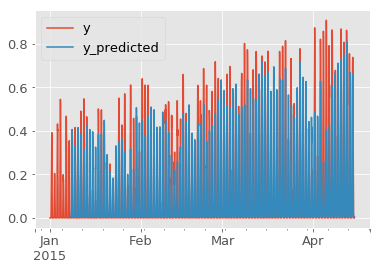

In [50]:
regression_frame_raw[[DEPENDENT, DEPENDENT + '_predicted']].plot()

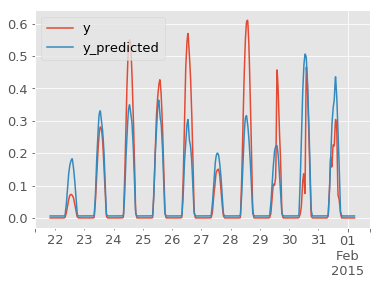

In [51]:
regression_frame_raw[[DEPENDENT, DEPENDENT + '_predicted']].iloc[2000:3000].plot()

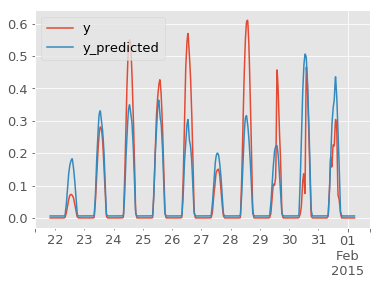

In [52]:
regression_frame_raw[[DEPENDENT, DEPENDENT + '_predicted']].iloc[2000:3000].plot()

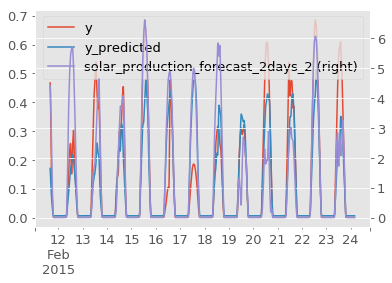

In [53]:
regression_frame_raw[[DEPENDENT, DEPENDENT + '_predicted','solar_production_forecast_2days_2']].iloc[4000:5200].plot(secondary_y=['solar_production_forecast_2days_2'])

In [54]:
sm.tools.eval_measures.rmse(y_test,y_hat_test, axis=0)

0.1315918049902972

In [55]:
## test set results

Text(0,0.5,'proportion')

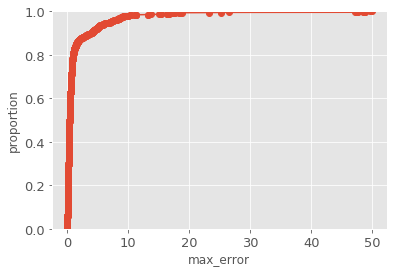

In [56]:
results_df = pd.DataFrame({'y_hat_test':y_hat_test,'y_test':y_test})

## remove 0 s
results_df=results_df[(results_df != 0).all(1)]

results_df['max_error'] = abs(results_df.y_hat_test/results_df.y_test-1)
## uncommet if you want to look at abs values
# results_df['max_error'] = abs(results_df.y_hat_test-results_df.y_test)

results_df.sort_values('max_error', inplace = True)
results_df['proportion'] = (np.arange(len(results_df))+1) / len(results_df)

plt.plot(results_df['max_error'],results_df['proportion'], '-o')
plt.ylim(0,1)
plt.xlabel('max_error')
plt.ylabel('proportion')


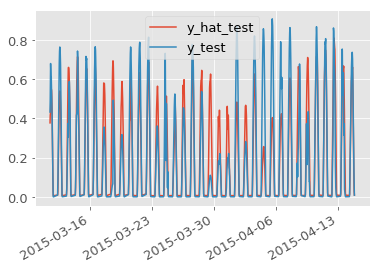

In [57]:
results_df[['y_hat_test','y_test']].plot()

## rolling forecast
___
create functions for model fitting, predicting, storing results etc.
this should include selecting the right time frames and predicting for the right dates. 
This is work in progress. 


In [58]:
regression_frame_raw = regression_frame_raw.iloc[:, regression_frame_raw.columns != 'y_predicted']

In [59]:
regression_frame_raw.head()

,y,solar_production,y_2,y_3,y_4,y_5,y_6,y_7,y_8,solar_production_forecast_2days,solar_production_forecast_2days_2
2015-01-01 00:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2015-01-01 00:15:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2015-01-01 00:30:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2015-01-01 00:45:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2015-01-01 01:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [60]:
## set training window in days 
TRAINING_WINDOW = 30
NUMBER_OF_PREDICTION_DAYS = 1

In [61]:
## set 'today' variable; this determines for what moment should be predicted.
today = datetime.datetime(2015,3,1,10)
today

datetime.datetime(2015, 3, 1, 10, 0)

In [62]:
## set more 'todays', same as above, but use this to predict more, using the rolling forecast
today_last = today + datetime.timedelta(days=NUMBER_OF_PREDICTION_DAYS)
dates_for_prediction = pd.date_range(today,today_last, freq='15T')


In [63]:
## create fitting function

In [ ]:
## model fitting function for fixed data set
## rolling forecasting method will follow below
def model_fitting(df, cur_date, dependent, independents, window):
    ''' Parameters
        df: DataFrame
        the data
        
        cur_date: datetime
        moment up to which data will be used for fitting the model
        
        dependent: str 
        dependent variable. variable to predict
        
        independets: list
        independent variable(s)
        
        window: int
        number of days that are used for training the model
        
        '''
    traing_date_first = cur_date - datetime.timedelta(days=window)
    training_data_indices = pd.date_range(traing_date_first,cur_date, freq='15T')
    
    regression_frame = df[[dependent] + independents].loc[training_data_indices]
    regression_frame = regression_frame[~pd.isnull(regression_frame).any(axis=1)]
    regression_frame['constant'] = 1

    X_train = regression_frame.iloc[:,1:]
    y_train = np.array(regression_frame.iloc[:,0])

    mod = sm.OLS(y_train,X_train)
    res = mod.fit()
    return res
    return regression_frame

In [ ]:
res = model_fitting(regression_frame_raw, datetime.datetime(2015,3,1,10),
                    DEPENDENT, INDEPENDENTS, TRAINING_WINDOW)
res

In [ ]:
## create prediction function for 48 hours after 'today'
## TBD